# Idea: Aula 2

# Physics-Informed Neural Networks (PINNs) with PyTorch

This notebook demonstrates the implementation of Physics-Informed Neural Networks for solving partial differential equations (PDEs).

## Overview

PINNs are neural networks that incorporate physical laws (PDEs) into the training process. They can:
- Solve forward problems (finding solutions given a PDE)
- Solve inverse problems (discovering parameters in a PDE)
- Work with sparse and noisy data

## Example Problem: 1D Heat Equation

We'll solve the heat equation:
$$\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$$

With boundary conditions:
- $u(0, t) = 0$ (left boundary)
- $u(1, t) = 0$ (right boundary)
- $u(x, 0) = \sin(\pi x)$ (initial condition)

## 1. Import Libraries

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from torch import (Tensor, abs, cat, device, exp, float32, linspace,
                   manual_seed, meshgrid, nn, no_grad, ones, ones_like, pi,
                   rand, sin, tanh, tensor, zeros, zeros_like)
from torch.autograd import grad
from torch.linalg import norm
from torch.optim import Adam

# from mpl_toolkits.mplot3d import Axes3D

In [58]:
# Set random seeds for reproducibility
manual_seed(42)

# Device configuration
cpu_device = device("cpu");
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('mps' if torch.backends.mps.is_available() else device)
# print(f"Using device: {device}")

## 2. Define the Neural Network Architecture

In [59]:
class PINN(nn.Module):
    """
    Physics-Informed Neural Network for solving PDEs.

    The network takes (x, t) as input and outputs u(x, t).
    """

    def __init__(self, layers):
        super().__init__()

        self.layers = nn.ModuleList()

        # Build the network
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))

        # Initialize weights using Xavier initialization
        self.init_weights()

    def init_weights(self):
        for layer in self.layers:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)

    def forward(self, x, t):
        # Concatenate inputs
        inputs = cat([x, t], dim=1)

        # Pass through hidden layers with tanh activation
        for i in range(len(self.layers) - 1):
            inputs = tanh(self.layers[i](inputs))

        # Output layer (no activation)
        output = self.layers[-1](inputs)

        return output

## 3. Physics-Informed Loss Functions

In [60]:
def compute_pde_residual(model, x, t, alpha=0.01):
    """
    Compute the PDE residual for the heat equation.

    PDE: du/dt - alpha * d2u/dx2 = 0
    """
    x.requires_grad = True
    t.requires_grad = True

    # Forward pass
    u = model(x, t)

    # Compute gradients
    u_x = grad(u, x, grad_outputs=ones_like(u), create_graph=True, retain_graph=True)[0]

    u_t = grad(u, t, grad_outputs=ones_like(u), create_graph=True, retain_graph=True)[0]

    # Second derivative with respect to x
    u_xx = grad(
        u_x, x, grad_outputs=ones_like(u_x), create_graph=True, retain_graph=True
    )[0]

    # PDE residual
    residual = u_t - alpha * u_xx

    return residual


def initial_condition(x):
    """
    Initial condition: u(x, 0) = sin(pi * x)
    """
    return sin(pi * x)


def boundary_condition(t):
    """
    Boundary conditions: u(0, t) = u(1, t) = 0
    """
    return zeros_like(t)

## 4. Training Function

In [61]:
def train_pinn(
    model,
    device,
    n_epochs=5000,
    lr=0.001,
    n_collocation=10000,
    n_initial=100,
    n_boundary=100,
    alpha=0.01,
):
    """
    Train the Physics-Informed Neural Network.

    Args:
        model: PINN model
        n_epochs: Number of training epochs
        lr: Learning rate
        n_collocation: Number of collocation points for PDE
        n_initial: Number of points for initial condition
        n_boundary: Number of points for boundary conditions
        alpha: Thermal diffusivity coefficient
        device: device
    """
    optimizer = Adam(model.parameters(), lr=lr)

    losses = []

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Generate collocation points for PDE (random points in domain)
        x_pde = rand(n_collocation, 1, requires_grad=True).to(device)
        t_pde = rand(n_collocation, 1, requires_grad=True).to(device)

        # Initial condition points (t=0)
        x_ic = rand(n_initial, 1).to(device)
        t_ic = zeros(n_initial, 1).to(device)
        u_ic = initial_condition(x_ic)

        # Boundary condition points (x=0 and x=1)
        t_bc = rand(n_boundary, 1).to(device)
        x_bc_left = zeros(n_boundary, 1).to(device)
        x_bc_right = ones(n_boundary, 1).to(device)
        u_bc = boundary_condition(t_bc)

        # Compute losses

        # 1. PDE residual loss
        residual = compute_pde_residual(model, x_pde, t_pde, alpha)
        loss_pde = (residual**2).mean()

        # 2. Initial condition loss
        u_pred_ic = model(x_ic, t_ic)
        loss_ic = ((u_pred_ic - u_ic) ** 2).mean()

        # 3. Boundary condition loss
        u_pred_bc_left = model(x_bc_left, t_bc)
        u_pred_bc_right = model(x_bc_right, t_bc)
        loss_bc = ((u_pred_bc_left - u_bc) ** 2).mean() + (
            (u_pred_bc_right - u_bc) ** 2
        ).mean()

        # Total loss
        loss = loss_pde + loss_ic + loss_bc

        # Backpropagation
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        # Print progress
        if (epoch + 1) % 500 == 0:
            print(
                f"Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.6f}, "
                f"PDE: {loss_pde.item():.6f}, IC: {loss_ic.item():.6f}, "
                f"BC: {loss_bc.item():.6f}"
            )

    return losses

## 5. Analytical Solution (for comparison)

In [62]:
def analytical_solution(x, t: float, alpha: float = 0.01):
    """
    Analytical solution for the 1D heat equation with given initial/boundary conditions.

    u(x, t) = sin(pi * x) * exp(-alpha * pi^2 * t)
    """
    if not isinstance(x, Tensor):
        x = tensor(x, dtype=float32)
    if not isinstance(t, Tensor):
        t = tensor(t, dtype=float32)
    return sin(pi * x) * exp(-alpha * pi**2 * t)

## 6. Train the Model

In [63]:
# Define network architecture
layers = [2, 32, 32, 32, 1]  # Input: (x, t), Output: u

# Create model
model = PINN(layers).to(cpu_device)
print(model)

# Thermal diffusivity
alpha = 0.01

# Train the model
print("\nTraining PINN...")
losses = train_pinn(model, cpu_device, n_epochs=500, lr=0.001, alpha=alpha)

PINN(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1-2): 2 x Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)

Training PINN...
Epoch [500/500], Loss: 0.004594, PDE: 0.001176, IC: 0.002395, BC: 0.001023


## 7. Visualize Training Loss

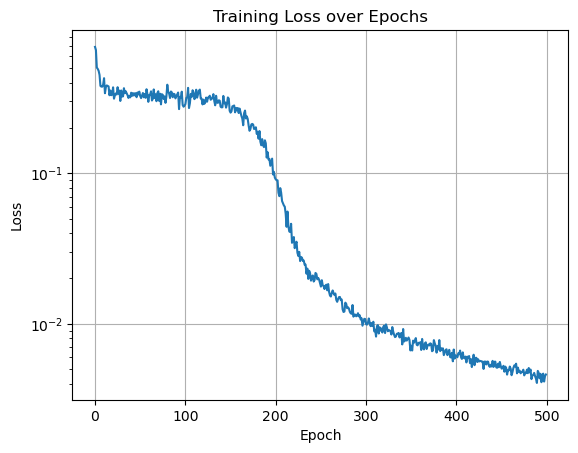

In [64]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.yscale("log")
plt.grid(True)

## 8. Evaluate and Compare with Analytical Solution

In [65]:
# Create a grid for evaluation, ensuring tensors are on the correct device from the start.
x_eval = linspace(0, 1, 100, device=cpu_device)
t_eval = linspace(0, 1, 100, device=cpu_device)
# Use 'xy' indexing for meshgrid to ensure correct dimensions for plotting.
X, T = meshgrid(x_eval, t_eval, indexing="xy")

# Predict with PINN on the flattened grid, avoiding intermediate variables.
model.eval()
with no_grad():
    u_pred = model(X.flatten().unsqueeze(1), T.flatten().unsqueeze(1))

# Reshape prediction and calculate analytical solution using torch tensors.
U_pred = u_pred.reshape(X.shape)
U_exact = analytical_solution(X, T, alpha)

# Compute and print relative L2 error entirely within PyTorch.
error = abs(U_pred - U_exact)
relative_error = norm(error) / norm(U_exact)
print(f"\nRelative L2 error: {relative_error.item():.6f}")


Relative L2 error: 0.065403


## 9. Visualize Results

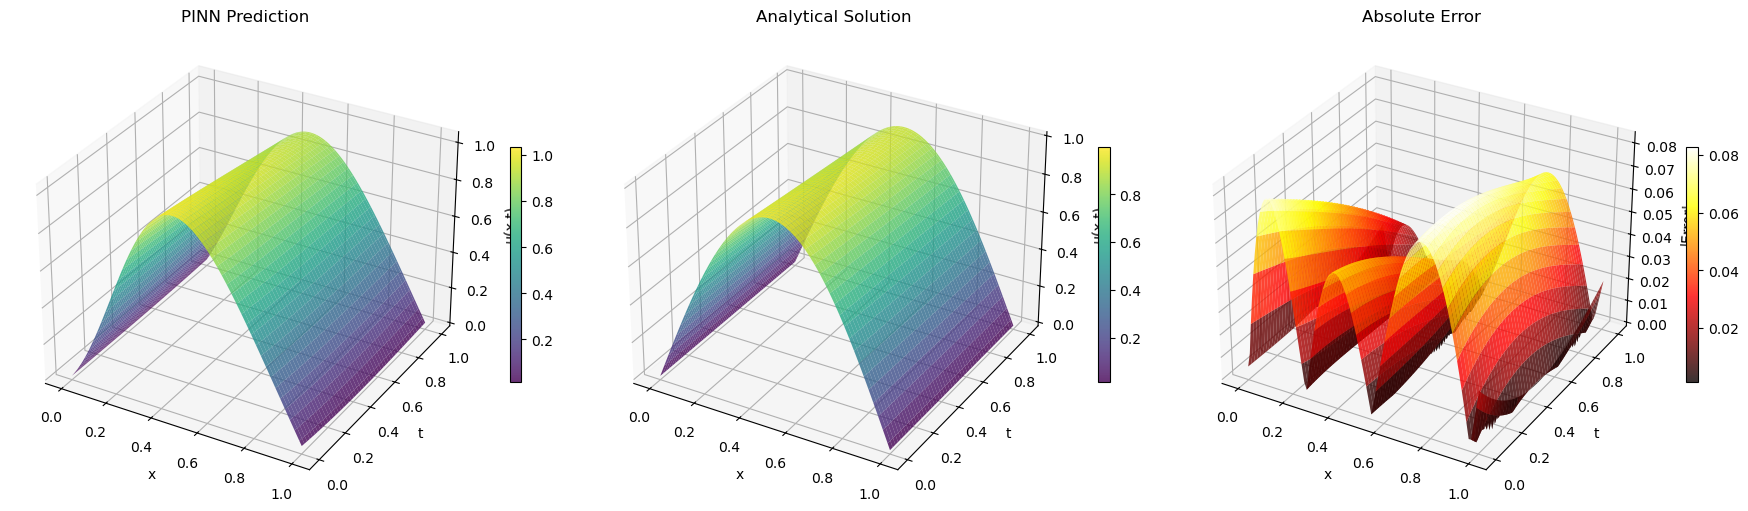

In [66]:
# 3D surface plots
fig = plt.figure(figsize=(18, 5))

# PINN prediction
ax1 = fig.add_subplot(131, projection="3d")
surf1 = ax1.plot_surface(X, T, U_pred, cmap=cm.viridis, alpha=0.8)
ax1.set_xlabel("x")
ax1.set_ylabel("t")
ax1.set_zlabel("u(x,t)")
ax1.set_title("PINN Prediction")
fig.colorbar(surf1, ax=ax1, shrink=0.5)

# Analytical solution
ax2 = fig.add_subplot(132, projection="3d")
surf2 = ax2.plot_surface(X, T, U_exact, cmap=cm.viridis, alpha=0.8)
ax2.set_xlabel("x")
ax2.set_ylabel("t")
ax2.set_zlabel("u(x,t)")
ax2.set_title("Analytical Solution")
fig.colorbar(surf2, ax=ax2, shrink=0.5)

# Error
ax3 = fig.add_subplot(133, projection="3d")
surf3 = ax3.plot_surface(X, T, error, cmap=cm.hot, alpha=0.8)
ax3.set_xlabel("x")
ax3.set_ylabel("t")
ax3.set_zlabel("|Error|")
ax3.set_title("Absolute Error")
fig.colorbar(surf3, ax=ax3, shrink=0.5)

plt.tight_layout()
plt.show()

## 10. Time Snapshots Comparison

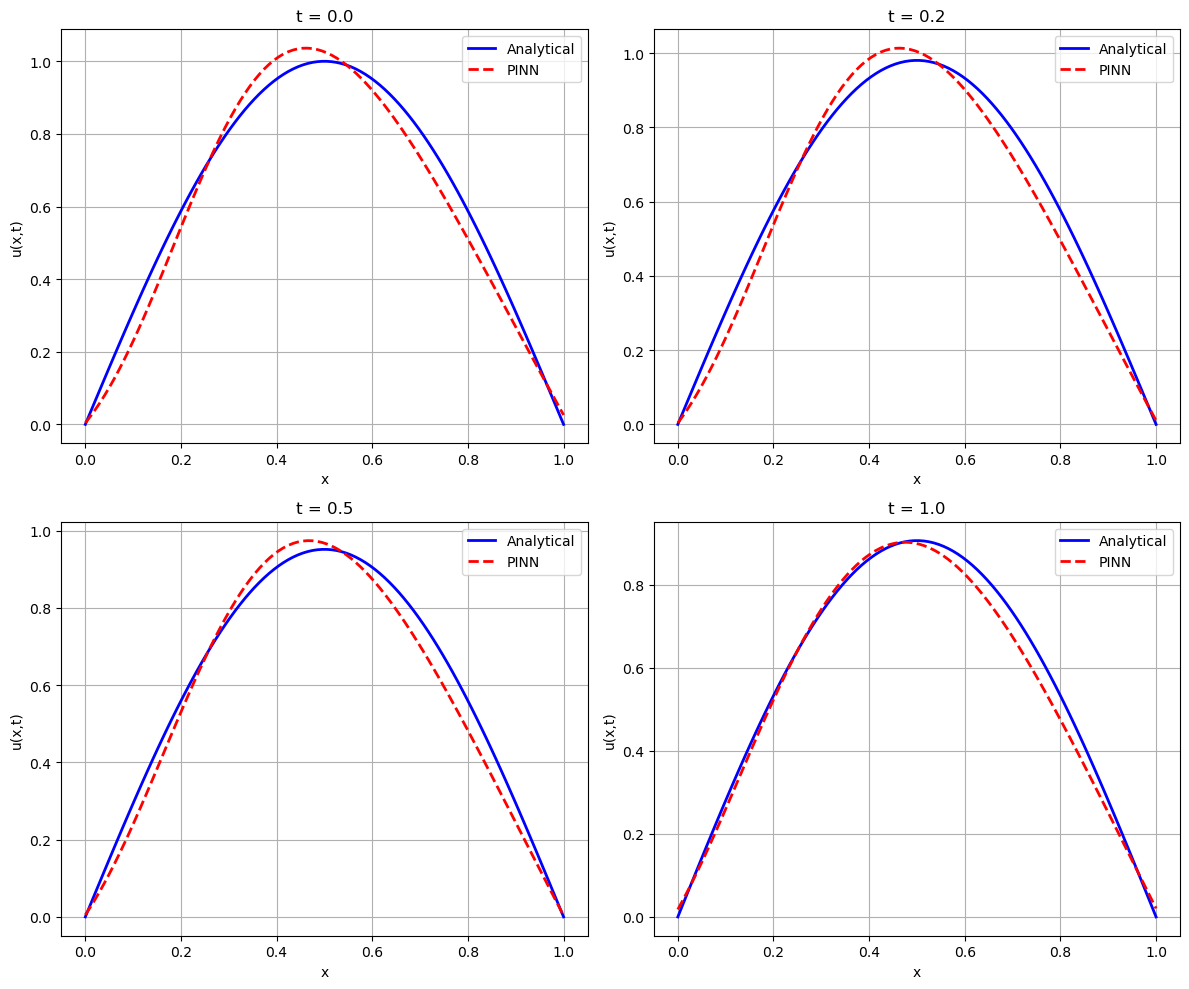

In [67]:
# Compare solutions at different time points
time_points = [0.0, 0.2, 0.5, 1.0]
# Use torch.linspace for the x-axis points, and place it on the device
x_plot = linspace(0, 1, 100, device=cpu_device)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

model.eval()  # Set model to evaluation mode for consistency

for idx, t_point in enumerate(time_points):
    # Prepare data as torch tensors on the correct device.
    # t_plot is a tensor of the same shape as x_plot, filled with the current time point.
    t_plot = ones_like(x_plot) * t_point

    # Reshape tensors to be column vectors (N, 1) for the model.
    x_tensor = x_plot.unsqueeze(1)
    t_tensor = t_plot.unsqueeze(1)

    # Get PINN prediction as a torch tensor, no need for .numpy().
    with no_grad():
        u_pred = model(x_tensor, t_tensor).flatten()

    # Calculate analytical solution using torch tensors.
    u_exact = analytical_solution(x_plot, t_point, alpha)

    # Plotting directly with torch tensors. Matplotlib handles them.
    # Moving to .cpu() is good practice if tensors were on GPU.
    axes[idx].plot(x_plot.cpu(), u_exact.cpu(), "b-", label="Analytical", linewidth=2)
    axes[idx].plot(x_plot.cpu(), u_pred.cpu(), "r--", label="PINN", linewidth=2)
    axes[idx].set_xlabel("x")
    axes[idx].set_ylabel("u(x,t)")
    axes[idx].set_title(f"t = {t_point}")
    axes[idx].legend()
    axes[idx].grid(True)

plt.tight_layout()
plt.show()

## 11. Advanced Example: Burgers' Equation

Let's implement a more complex example with Burgers' equation:
$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}$$

This is a nonlinear PDE that models fluid dynamics.

In [ ]:
# def compute_burgers_residual(model, x, t, nu=0.01):
#     """
#     Compute the PDE residual for Burgers' equation.

#     PDE: du/dt + u * du/dx - nu * d2u/dx2 = 0
#     """
#     x.requires_grad = True
#     t.requires_grad = True

#     u = model(x, t)

#     u_x = torch.autograd.grad(
#         u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True
#     )[0]

#     u_t = torch.autograd.grad(
#         u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True
#     )[0]

#     u_xx = torch.autograd.grad(
#         u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True
#     )[0]

#     # Burgers' equation residual (nonlinear term: u * u_x)
#     residual = u_t + u * u_x - nu * u_xx

#     return residual


# print("Burgers' equation PINN implementation ready!")

## Summary

This notebook demonstrated:

1. **PINN Architecture**: A simple feedforward neural network that takes spatial and temporal coordinates as input
2. **Physics-Informed Loss**: Combining PDE residuals with initial and boundary conditions
3. **Automatic Differentiation**: Using PyTorch's autograd to compute derivatives needed for the PDE
4. **Training**: Optimizing the network to satisfy both data and physics constraints
5. **Validation**: Comparing PINN predictions with analytical solutions

## Key Advantages of PINNs:

- Can handle irregular geometries
- Work with sparse and noisy data
- Can solve inverse problems (parameter estimation)
- Mesh-free approach
- Can incorporate multiple physical constraints

## Further Extensions:

- Multi-dimensional PDEs
- Time-dependent boundary conditions
- Inverse problems (parameter discovery)
- Complex geometries
- Systems of PDEs